<a href="https://colab.research.google.com/github/vindhya-jain/Advanced-Scientific-Calculator-in-C/blob/main/Spectrogram_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [1]:
import os
import shutil
import librosa
import librosa.display
import numpy as np
import random
import matplotlib.pyplot as plt
from kagglehub import dataset_download
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

### Load and Prepare Data

In [23]:
emotion_labels = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

In [3]:
path = dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

speech_output_path = "/content/ravdess_speech"
os.makedirs(speech_output_path, exist_ok=True)

100%|██████████| 429M/429M [00:02<00:00, 153MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [83]:
def filter_speech_files(path, output_path):
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split("-")

                if parts[0] == "03" and parts[1] == "01":
                    src_path = os.path.join(root, file)
                    dest_path = os.path.join(output_path, file)
                    shutil.copy(src_path, dest_path)
    print(f"Speech audio files saved to: {output_path}")

filter_speech_files(path, speech_output_path)

Speech audio files saved to: /content/ravdess_speech


In [84]:
def save_spectrogram(file_path, output_dir):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')

    filename = os.path.basename(file_path).replace(".wav", ".png")
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()

spectrogram_output_path = "/content/ravdess_spectrograms"
os.makedirs(spectrogram_output_path, exist_ok=True)

In [85]:
def process_dataset(directory, output_dir):
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            save_spectrogram(file_path, output_dir)

process_dataset(speech_output_path, spectrogram_output_path)
print("Spectrogram generation complete. Images saved to:", spectrogram_output_path)

Spectrogram generation complete. Images saved to: /content/ravdess_spectrograms


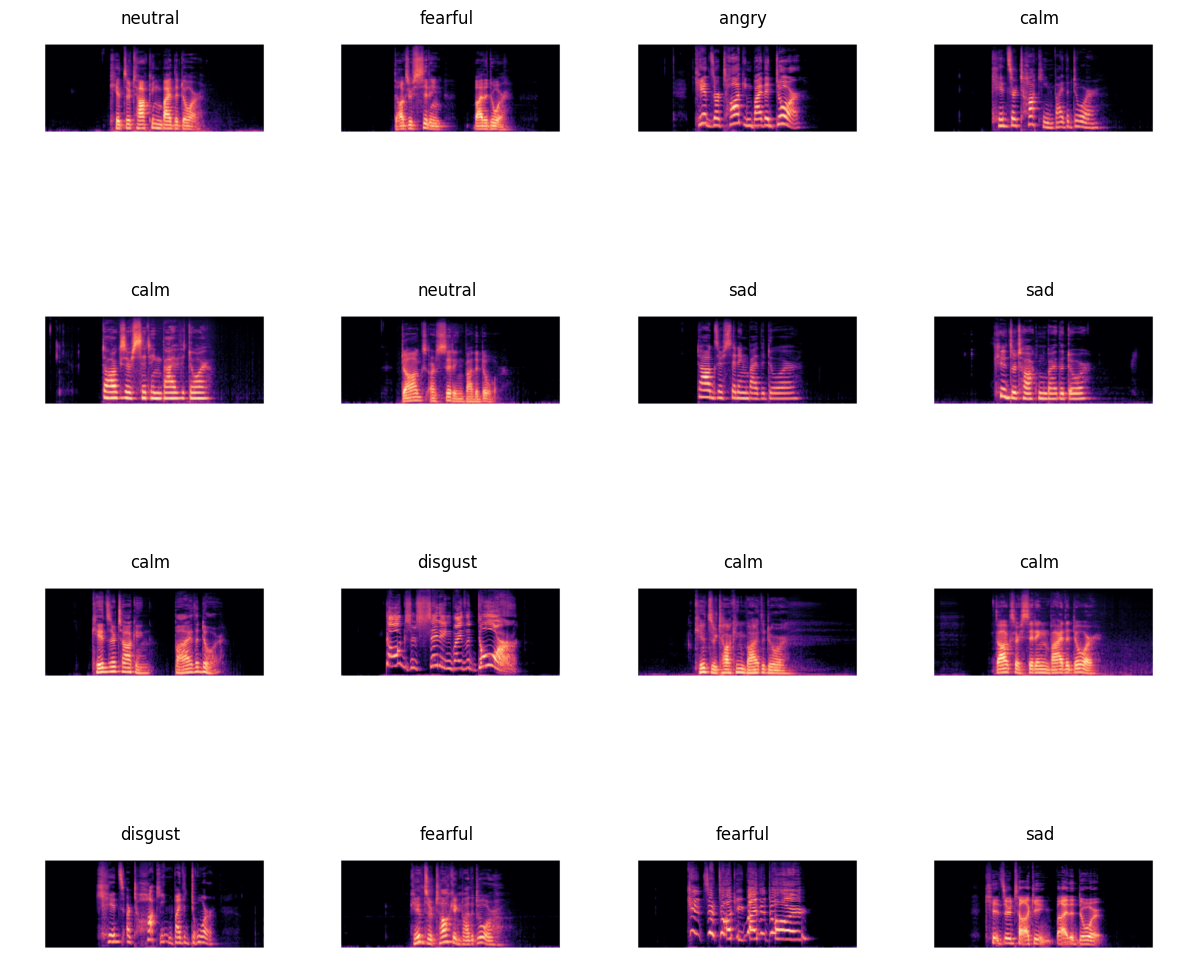

In [86]:
def display_spectrograms(output_dir, num_images=16):
    files = [f for f in os.listdir(output_dir) if f.endswith(".png")][:num_images]
    num_rows, num_cols = 4, 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for ax, file in zip(axes.flatten(), files):
        img = plt.imread(os.path.join(output_dir, file))
        emotion_id = int(file.split("-")[2])
        emotion = emotion_labels.get(emotion_id, "unknown")
        ax.imshow(img)
        ax.set_title(emotion)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

display_spectrograms(spectrogram_output_path)

In [87]:
class SpectrogramAugment:
    def __init__(self, time_mask_param=40, freq_mask_param=15, gaussian_noise=True):
        self.time_mask_param = time_mask_param
        self.freq_mask_param = freq_mask_param
        self.gaussian_noise = gaussian_noise

    def time_mask(self, spec):
        """Randomly masks a portion of time axis."""
        t = spec.shape[-1]
        t0 = random.randint(0, max(1, t - self.time_mask_param))
        spec[:, :, t0:t0 + self.time_mask_param] = 0
        return spec

    def freq_mask(self, spec):
        """Randomly masks a portion of frequency axis."""
        f = spec.shape[-2]
        f0 = random.randint(0, max(1, f - self.freq_mask_param))
        spec[:, f0:f0 + self.freq_mask_param, :] = 0
        return spec

    def add_gaussian_noise(self, spec, std=0.01):
        """Adds Gaussian noise to the spectrogram."""
        noise = torch.randn_like(spec) * std
        return spec + noise

    def __call__(self, image):
        """Apply augmentations."""
        spec = transforms.ToTensor()(image)

        # if random.random() < 0.2:
        #     spec = self.time_mask(spec)
        # if random.random() < 0.2:
        #     spec = self.freq_mask(spec)
        # if self.gaussian_noise and random.random() < 0.2:
        #     spec = self.add_gaussian_noise(spec)

        return spec

In [88]:
class SpectrogramDataset(Dataset):
    def __init__(self, image_dir, transform=None, augment=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
        self.transform = transform
        self.augment = augment
        self.resize = transforms.Resize((128, 128))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        image = self.resize(image)

        emotion_id = int(img_name.split("-")[2])
        label = torch.tensor(emotion_id - 1, dtype=torch.long)

        if self.augment:
            image = self.augment(image)

        if self.transform:
            image = self.transform(image) if isinstance(image, Image.Image) else image

        return image, label

In [89]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

spectrogram_augment = SpectrogramAugment(time_mask_param=40, freq_mask_param=15)
dataset = SpectrogramDataset(spectrogram_output_path, transform=transform, augment=spectrogram_augment)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train Dataloader size:", len(train_dataset))
print("Validation Dataloader size:", len(val_dataset))
print("Test Dataloader size:", len(test_dataset))

Train Dataloader size: 1007
Validation Dataloader size: 216
Test Dataloader size: 217


In [90]:
images, labels = next(iter(train_loader))
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([64, 3, 128, 128]) torch.Size([64])


### Training and Evaluating Functions

In [12]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, min_delta=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    prev_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if abs(prev_val_loss - val_loss) < min_delta:
            print(f"Stopping early: Validation loss stabilized")
            break

        prev_val_loss = val_loss

    # plot training vs validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return model

In [24]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    label_names = [emotion_labels[i + 1] for i in range(len(emotion_labels))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Implementation

#### CNN 3 Layers

In [113]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Epoch 1/50 - Train Loss: 4.8804, Train Acc: 0.1688, Val Loss: 2.1987, Val Acc: 0.1574
Epoch 2/50 - Train Loss: 2.0502, Train Acc: 0.2234, Val Loss: 1.9972, Val Acc: 0.2176
Epoch 3/50 - Train Loss: 1.7189, Train Acc: 0.3505, Val Loss: 1.7802, Val Acc: 0.3287
Epoch 4/50 - Train Loss: 1.4662, Train Acc: 0.4548, Val Loss: 1.8129, Val Acc: 0.3009
Epoch 5/50 - Train Loss: 1.3973, Train Acc: 0.5045, Val Loss: 1.5940, Val Acc: 0.4491
Epoch 6/50 - Train Loss: 1.1877, Train Acc: 0.5760, Val Loss: 1.4838, Val Acc: 0.4769
Epoch 7/50 - Train Loss: 1.0865, Train Acc: 0.6117, Val Loss: 1.2952, Val Acc: 0.5417
Epoch 8/50 - Train Loss: 0.9047, Train Acc: 0.6634, Val Loss: 1.4319, Val Acc: 0.4259
Epoch 9/50 - Train Loss: 0.7906, Train Acc: 0.7279, Val Loss: 1.5294, Val Acc: 0.5185
Epoch 10/50 - Train Loss: 0.6343, Train Acc: 0.7954, Val Loss: 1.1423, Val Acc: 0.5972
Epoch 11/50 - Train Loss: 0.5886, Train Acc: 0.7934, Val Loss: 1.1310, Val Acc: 0.5787
Epoch 12/50 - Train Loss: 0.4314, Train Acc: 0.8699,

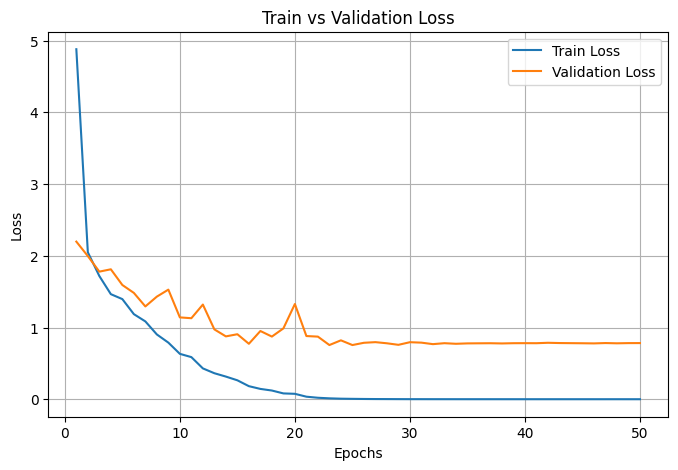

In [19]:
model = CNN3()
trained_model = train_model(model, train_loader, val_loader, epochs=50)

Accuracy: 0.7512
Precision: 0.7719, Recall: 0.7512, F1-score: 0.7497


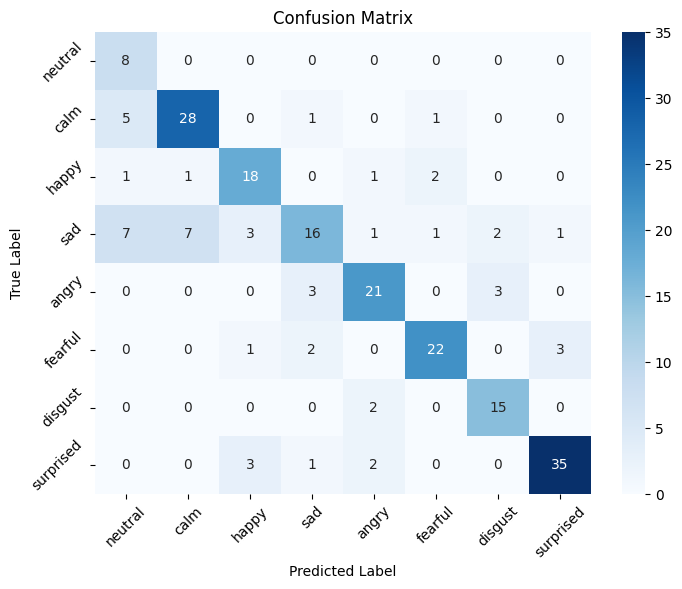

In [25]:
evaluate_model(trained_model, test_loader)

#### CNN 4 Layers

In [31]:
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Epoch 1/50 - Train Loss: 2.8104, Train Acc: 0.1370, Val Loss: 2.0954, Val Acc: 0.1713
Epoch 2/50 - Train Loss: 1.9026, Train Acc: 0.2810, Val Loss: 2.1239, Val Acc: 0.1944
Epoch 3/50 - Train Loss: 1.7134, Train Acc: 0.3615, Val Loss: 1.9133, Val Acc: 0.2685
Epoch 4/50 - Train Loss: 1.4764, Train Acc: 0.4548, Val Loss: 1.6539, Val Acc: 0.3148
Epoch 5/50 - Train Loss: 1.3667, Train Acc: 0.5015, Val Loss: 1.5690, Val Acc: 0.4815
Epoch 6/50 - Train Loss: 1.2081, Train Acc: 0.5521, Val Loss: 1.3026, Val Acc: 0.4769
Epoch 7/50 - Train Loss: 1.0520, Train Acc: 0.6236, Val Loss: 1.2588, Val Acc: 0.5602
Epoch 8/50 - Train Loss: 0.9141, Train Acc: 0.6713, Val Loss: 1.7289, Val Acc: 0.4120
Epoch 9/50 - Train Loss: 0.8284, Train Acc: 0.7071, Val Loss: 1.3764, Val Acc: 0.4861
Epoch 10/50 - Train Loss: 0.7351, Train Acc: 0.7438, Val Loss: 1.1807, Val Acc: 0.6343
Epoch 11/50 - Train Loss: 0.6520, Train Acc: 0.7686, Val Loss: 1.1001, Val Acc: 0.6343
Epoch 12/50 - Train Loss: 0.5170, Train Acc: 0.8292,

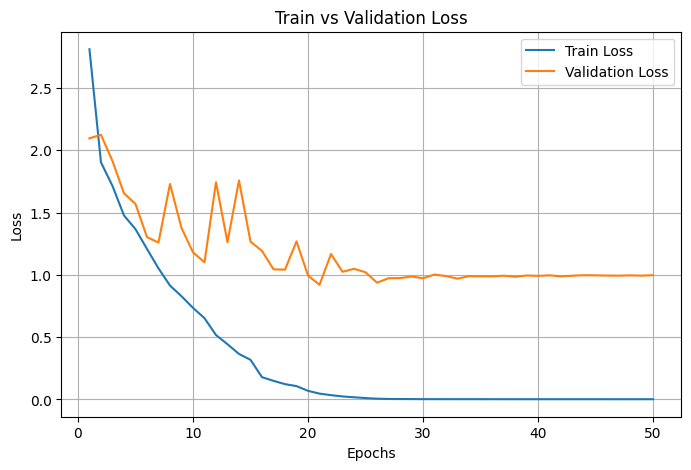

In [40]:
model = CNN4()
trained_model = train_model(model, train_loader, val_loader, epochs=50)

Accuracy: 0.7788
Precision: 0.7989, Recall: 0.7788, F1-score: 0.7738


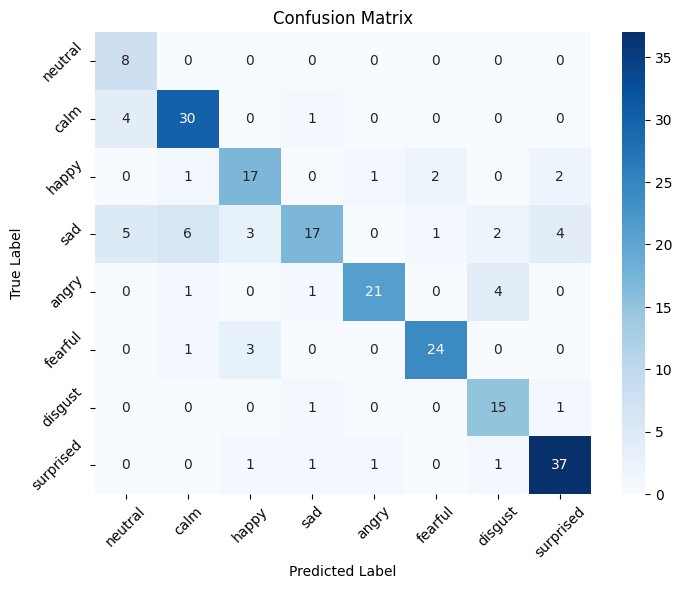

In [41]:
evaluate_model(trained_model, test_loader)

#### CNN 5 Layers

In [28]:
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)  # Regularization

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 4 * 4)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.fc3(x)

Epoch 1/50 - Train Loss: 2.4991, Train Acc: 0.1261, Val Loss: 2.0997, Val Acc: 0.1389
Epoch 2/50 - Train Loss: 2.0698, Train Acc: 0.1539, Val Loss: 2.0438, Val Acc: 0.1528
Epoch 3/50 - Train Loss: 1.8560, Train Acc: 0.2761, Val Loss: 1.8614, Val Acc: 0.2315
Epoch 4/50 - Train Loss: 1.6907, Train Acc: 0.3436, Val Loss: 1.8720, Val Acc: 0.2130
Epoch 5/50 - Train Loss: 1.5360, Train Acc: 0.3962, Val Loss: 2.1458, Val Acc: 0.2454
Epoch 6/50 - Train Loss: 1.4484, Train Acc: 0.4558, Val Loss: 1.8680, Val Acc: 0.3472
Epoch 7/50 - Train Loss: 1.3492, Train Acc: 0.5065, Val Loss: 1.5329, Val Acc: 0.3889
Epoch 8/50 - Train Loss: 1.2645, Train Acc: 0.5243, Val Loss: 3.3307, Val Acc: 0.2176
Epoch 9/50 - Train Loss: 1.1277, Train Acc: 0.5899, Val Loss: 1.7340, Val Acc: 0.3426
Epoch 10/50 - Train Loss: 1.1132, Train Acc: 0.5631, Val Loss: 2.2175, Val Acc: 0.2454
Epoch 11/50 - Train Loss: 0.9933, Train Acc: 0.6137, Val Loss: 2.0200, Val Acc: 0.3380
Epoch 12/50 - Train Loss: 0.8030, Train Acc: 0.6922,

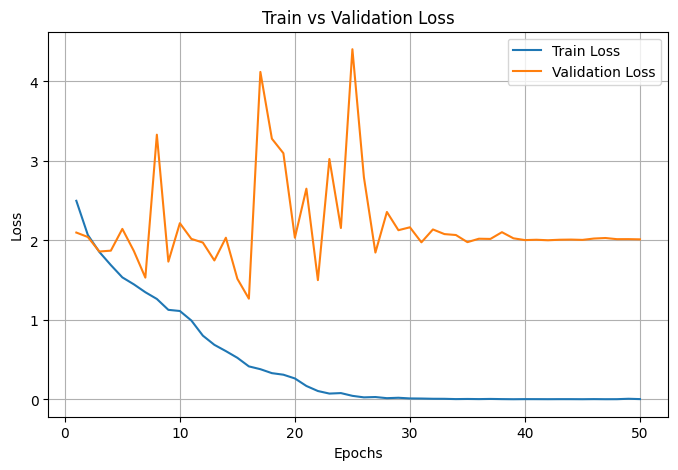

In [29]:
model = CNN5()
trained_model = train_model(model, train_loader, val_loader, epochs=50)

Accuracy: 0.6728
Precision: 0.6834, Recall: 0.6728, F1-score: 0.6702


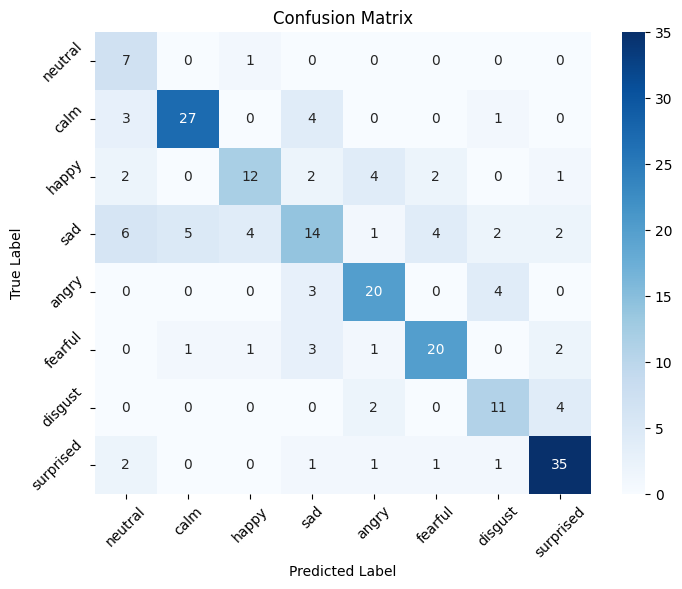

In [30]:
evaluate_model(model, test_loader)

#### With Greedy Layer-wise  Unsupervised Pretraining

In [ ]:
class ConvAutoencoder(nn.Module):
    """Autoencoder for layer-wise pretraining"""
    def __init__(self, in_channels, out_channels):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.decoder = nn.Conv2d(out_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.encoder(x))
        return x

def pretrain_layer(layer, feature_loader, device, epochs=20, lr=0.001):
    """Pretrain a single Conv layer as an autoencoder"""
    model = ConvAutoencoder(layer.in_channels, layer.out_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in feature_loader:
            images = batch[0].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Layer {layer.in_channels}->{layer.out_channels}, Epoch {epoch+1}, Loss: {total_loss / len(feature_loader):.4f}")

    return model.encoder

def replace_pretrained_weights(cnn_model, pretrained_layer, target_layer):
    """Copy pretrained weights into the CNN"""
    target_layer.weight.data = pretrained_layer.weight.data
    target_layer.bias.data = pretrained_layer.bias.data

#####Finetuning for 25 epochs

In [102]:
model = CNN3().to(device)

train_images, _ = next(iter(train_loader))
train_images = train_images.to(device)

features = train_images

for i, layer in enumerate([model.conv1, model.conv2, model.conv3]):
    print(f"\nPretraining Conv Layer {i+1} ({layer.in_channels} -> {layer.out_channels})")

    feature_dataset = TensorDataset(features)
    feature_loader = DataLoader(feature_dataset, batch_size=32, shuffle=True)

    pretrained_layer = pretrain_layer(layer, feature_loader, device, epochs=50)
    replace_pretrained_weights(model, pretrained_layer, layer)

    # generate feature maps for next layer
    with torch.no_grad():
        features = F.relu(layer(features))


Pretraining Conv Layer 1 (3 -> 16)
Layer 3->16, Epoch 1, Loss: 0.2096
Layer 3->16, Epoch 2, Loss: 0.2011
Layer 3->16, Epoch 3, Loss: 0.1929
Layer 3->16, Epoch 4, Loss: 0.1853
Layer 3->16, Epoch 5, Loss: 0.1779
Layer 3->16, Epoch 6, Loss: 0.1704
Layer 3->16, Epoch 7, Loss: 0.1627
Layer 3->16, Epoch 8, Loss: 0.1548
Layer 3->16, Epoch 9, Loss: 0.1467
Layer 3->16, Epoch 10, Loss: 0.1388
Layer 3->16, Epoch 11, Loss: 0.1312
Layer 3->16, Epoch 12, Loss: 0.1245
Layer 3->16, Epoch 13, Loss: 0.1189
Layer 3->16, Epoch 14, Loss: 0.1141
Layer 3->16, Epoch 15, Loss: 0.1102
Layer 3->16, Epoch 16, Loss: 0.1069
Layer 3->16, Epoch 17, Loss: 0.1040
Layer 3->16, Epoch 18, Loss: 0.1011
Layer 3->16, Epoch 19, Loss: 0.0981
Layer 3->16, Epoch 20, Loss: 0.0947
Layer 3->16, Epoch 21, Loss: 0.0909
Layer 3->16, Epoch 22, Loss: 0.0871
Layer 3->16, Epoch 23, Loss: 0.0832
Layer 3->16, Epoch 24, Loss: 0.0798
Layer 3->16, Epoch 25, Loss: 0.0765
Layer 3->16, Epoch 26, Loss: 0.0733
Layer 3->16, Epoch 27, Loss: 0.0699
L

Epoch 1/25 - Train Loss: 5.0436, Train Acc: 0.1539, Val Loss: 2.4925, Val Acc: 0.1250
Epoch 2/25 - Train Loss: 2.0273, Train Acc: 0.2552, Val Loss: 2.1825, Val Acc: 0.2083
Epoch 3/25 - Train Loss: 1.7861, Train Acc: 0.3426, Val Loss: 1.9380, Val Acc: 0.2963
Epoch 4/25 - Train Loss: 1.6249, Train Acc: 0.3932, Val Loss: 1.7142, Val Acc: 0.3009
Epoch 5/25 - Train Loss: 1.3558, Train Acc: 0.5084, Val Loss: 2.1854, Val Acc: 0.2454
Epoch 6/25 - Train Loss: 1.1885, Train Acc: 0.5561, Val Loss: 1.4891, Val Acc: 0.4491
Epoch 7/25 - Train Loss: 1.0336, Train Acc: 0.6246, Val Loss: 1.5290, Val Acc: 0.4722
Epoch 8/25 - Train Loss: 0.8940, Train Acc: 0.6902, Val Loss: 1.2147, Val Acc: 0.6019
Epoch 9/25 - Train Loss: 0.7674, Train Acc: 0.7219, Val Loss: 1.3462, Val Acc: 0.5463
Epoch 10/25 - Train Loss: 0.6478, Train Acc: 0.7686, Val Loss: 1.2203, Val Acc: 0.5741
Epoch 11/25 - Train Loss: 0.5646, Train Acc: 0.8193, Val Loss: 1.0875, Val Acc: 0.6157
Epoch 12/25 - Train Loss: 0.4811, Train Acc: 0.8292,

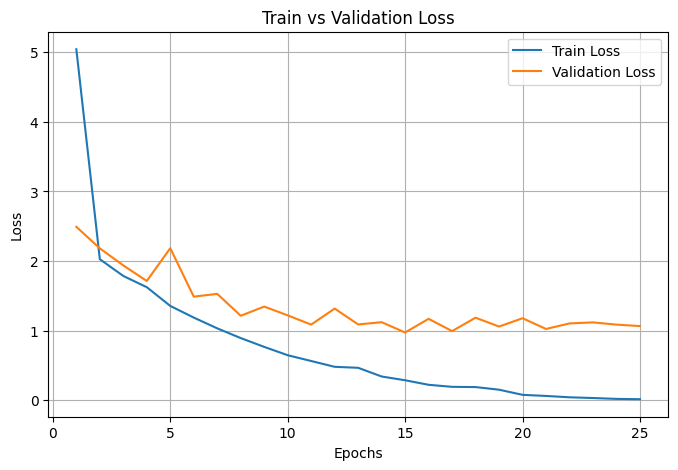

In [103]:
trained_model = train_model(model, train_loader, val_loader, epochs=25)

Accuracy: 0.7005
Precision: 0.7174, Recall: 0.7005, F1-score: 0.7018


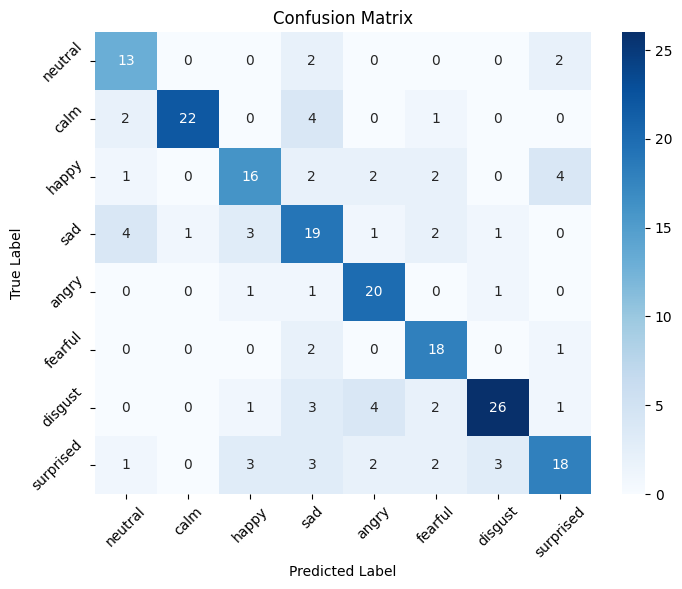

In [104]:
evaluate_model(trained_model, test_loader)

##### Finetuning for 30 epochs

In [114]:
model = CNN3().to(device)

train_images, _ = next(iter(train_loader))
train_images = train_images.to(device)

features = train_images

for i, layer in enumerate([model.conv1, model.conv2, model.conv3]):
    print(f"\nPretraining Conv Layer {i+1} ({layer.in_channels} -> {layer.out_channels})")

    feature_dataset = TensorDataset(features)
    feature_loader = DataLoader(feature_dataset, batch_size=32, shuffle=True)

    pretrained_layer = pretrain_layer(layer, feature_loader, device, epochs=50)
    replace_pretrained_weights(model, pretrained_layer, layer)

    # generate feature maps for next layer
    with torch.no_grad():
        features = F.relu(layer(features))


Pretraining Conv Layer 1 (3 -> 16)
Layer 3->16, Epoch 1, Loss: 0.1907
Layer 3->16, Epoch 2, Loss: 0.1847
Layer 3->16, Epoch 3, Loss: 0.1790
Layer 3->16, Epoch 4, Loss: 0.1736
Layer 3->16, Epoch 5, Loss: 0.1681
Layer 3->16, Epoch 6, Loss: 0.1623
Layer 3->16, Epoch 7, Loss: 0.1561
Layer 3->16, Epoch 8, Loss: 0.1494
Layer 3->16, Epoch 9, Loss: 0.1426
Layer 3->16, Epoch 10, Loss: 0.1358
Layer 3->16, Epoch 11, Loss: 0.1289
Layer 3->16, Epoch 12, Loss: 0.1226
Layer 3->16, Epoch 13, Loss: 0.1165
Layer 3->16, Epoch 14, Loss: 0.1110
Layer 3->16, Epoch 15, Loss: 0.1063
Layer 3->16, Epoch 16, Loss: 0.1023
Layer 3->16, Epoch 17, Loss: 0.0991
Layer 3->16, Epoch 18, Loss: 0.0962
Layer 3->16, Epoch 19, Loss: 0.0933
Layer 3->16, Epoch 20, Loss: 0.0905
Layer 3->16, Epoch 21, Loss: 0.0876
Layer 3->16, Epoch 22, Loss: 0.0845
Layer 3->16, Epoch 23, Loss: 0.0813
Layer 3->16, Epoch 24, Loss: 0.0780
Layer 3->16, Epoch 25, Loss: 0.0748
Layer 3->16, Epoch 26, Loss: 0.0717
Layer 3->16, Epoch 27, Loss: 0.0686
L

Epoch 1/30 - Train Loss: 5.2136, Train Acc: 0.1589, Val Loss: 3.1994, Val Acc: 0.1389
Epoch 2/30 - Train Loss: 2.1341, Train Acc: 0.2453, Val Loss: 2.2206, Val Acc: 0.1389
Epoch 3/30 - Train Loss: 1.6349, Train Acc: 0.3704, Val Loss: 1.9683, Val Acc: 0.3148
Epoch 4/30 - Train Loss: 1.3879, Train Acc: 0.4945, Val Loss: 1.5706, Val Acc: 0.4537
Epoch 5/30 - Train Loss: 1.2988, Train Acc: 0.5184, Val Loss: 1.5820, Val Acc: 0.4537
Epoch 6/30 - Train Loss: 1.0646, Train Acc: 0.6286, Val Loss: 1.3779, Val Acc: 0.5602
Epoch 7/30 - Train Loss: 1.0059, Train Acc: 0.6336, Val Loss: 1.2332, Val Acc: 0.5741
Epoch 8/30 - Train Loss: 0.8967, Train Acc: 0.6773, Val Loss: 1.1182, Val Acc: 0.6111
Epoch 9/30 - Train Loss: 0.7362, Train Acc: 0.7438, Val Loss: 1.0907, Val Acc: 0.6065
Epoch 10/30 - Train Loss: 0.5866, Train Acc: 0.8093, Val Loss: 1.2277, Val Acc: 0.5880
Epoch 11/30 - Train Loss: 0.5758, Train Acc: 0.8044, Val Loss: 1.2190, Val Acc: 0.6019
Epoch 12/30 - Train Loss: 0.4639, Train Acc: 0.8292,

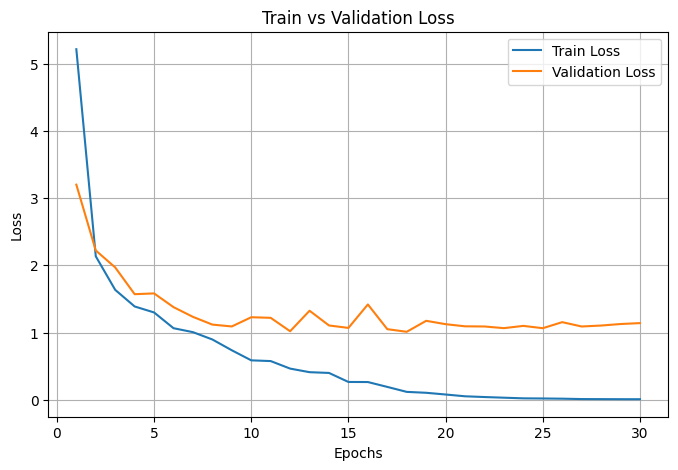

In [115]:
trained_model = train_model(model, train_loader, val_loader, epochs=30)

Accuracy: 0.7281
Precision: 0.7277, Recall: 0.7281, F1-score: 0.7243


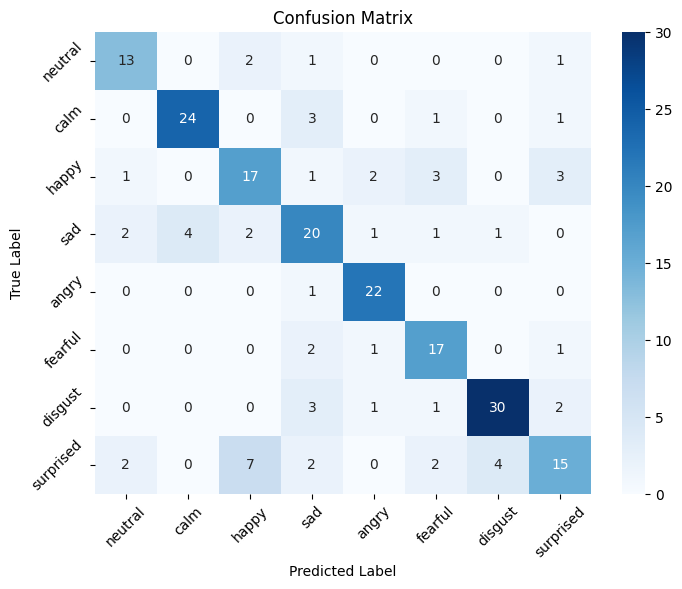

In [116]:
evaluate_model(trained_model, test_loader)

### Adding augmentation to the spectrograms

In [46]:
def preprocess_audio(file_path, target_sample_rate=16000, num_samples=32000):
    waveform, sample_rate = torchaudio.load(file_path)

    if sample_rate != target_sample_rate:
        waveform = T.Resample(sample_rate, target_sample_rate)(waveform)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    if waveform.shape[1] > num_samples:
        waveform = waveform[:, :num_samples]
    else:
        pad_amount = num_samples - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount))

    return waveform.numpy().squeeze(), target_sample_rate

In [47]:
def save_spectrogram(file_path, output_dir):
    y, sr = preprocess_audio(file_path)

    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')

    filename = os.path.basename(file_path).replace(".wav", ".png")
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', pad_inches=0)
    plt.close()

In [48]:
process_dataset(speech_output_path, spectrogram_output_path)
print("Spectrogram generation complete. Images saved to:", spectrogram_output_path)

Spectrogram generation complete. Images saved to: /content/ravdess_spectrograms


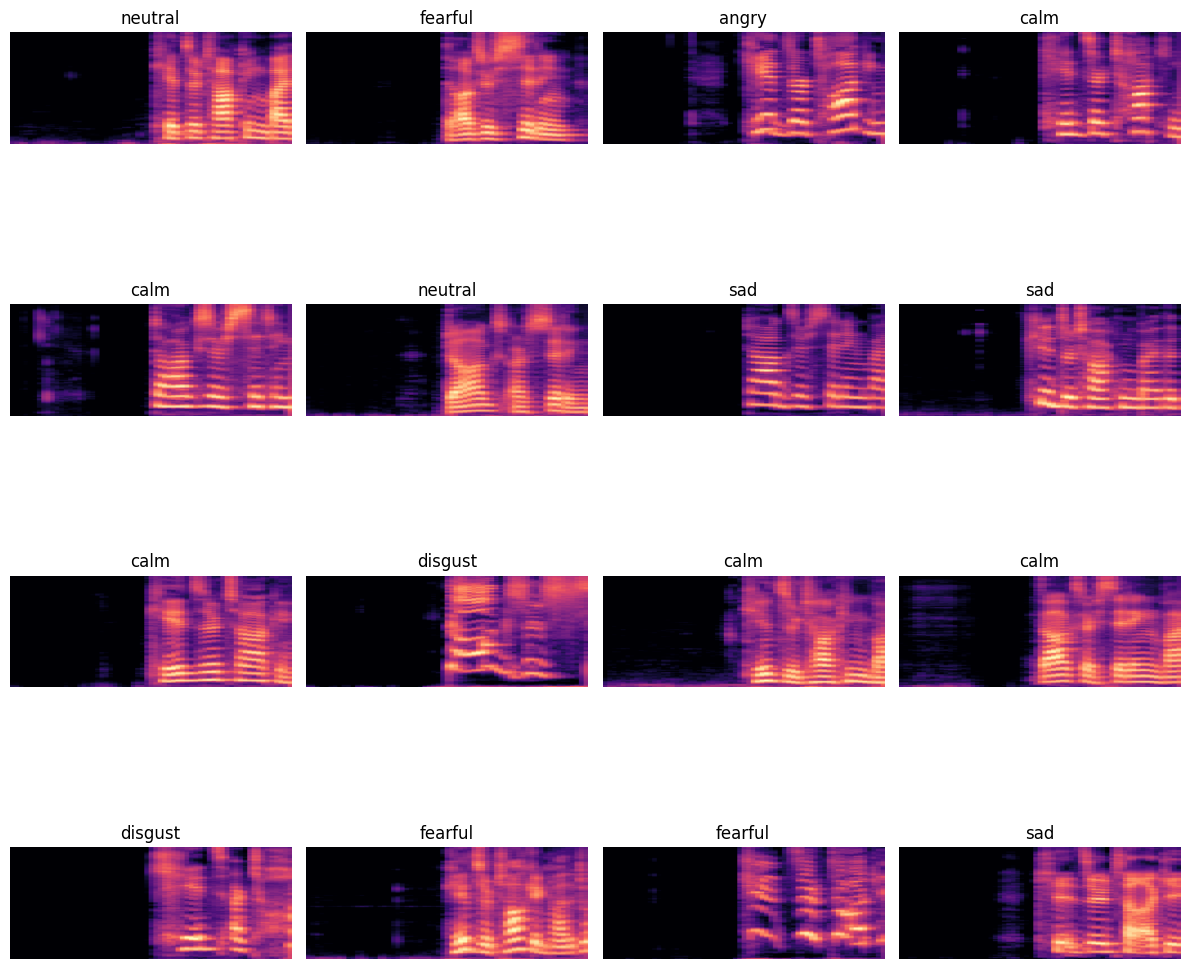

In [49]:
display_spectrograms(spectrogram_output_path)

In [50]:
class SpectrogramAugment:
    def __init__(self, time_mask_param=40, freq_mask_param=15, gaussian_noise=True):
        self.time_mask_param = time_mask_param
        self.freq_mask_param = freq_mask_param
        self.gaussian_noise = gaussian_noise

    def time_mask(self, spec):
        """Randomly masks a portion of time axis."""
        t = spec.shape[-1]
        t0 = random.randint(0, max(1, t - self.time_mask_param))
        spec[:, :, t0:t0 + self.time_mask_param] = 0
        return spec

    def freq_mask(self, spec):
        """Randomly masks a portion of frequency axis."""
        f = spec.shape[-2]
        f0 = random.randint(0, max(1, f - self.freq_mask_param))
        spec[:, f0:f0 + self.freq_mask_param, :] = 0
        return spec

    def add_gaussian_noise(self, spec, std=0.01):
        """Adds Gaussian noise to the spectrogram."""
        noise = torch.randn_like(spec) * std
        return spec + noise

    def __call__(self, image):
        """Apply augmentations."""
        spec = transforms.ToTensor()(image)

        if random.random() < 0.2:
            spec = self.time_mask(spec)
        if random.random() < 0.2:
            spec = self.freq_mask(spec)
        if self.gaussian_noise and random.random() < 0.2:
            spec = self.add_gaussian_noise(spec)

        return spec

In [51]:
class SpectrogramDataset(Dataset):
    def __init__(self, image_dir, transform=None, augment=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
        self.transform = transform
        self.augment = augment
        self.resize = transforms.Resize((128, 128))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        image = self.resize(image)

        emotion_id = int(img_name.split("-")[2])
        label = torch.tensor(emotion_id - 1, dtype=torch.long)

        if self.augment:
            image = self.augment(image)

        if self.transform:
            image = self.transform(image) if isinstance(image, Image.Image) else image

        return image, label

In [52]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

spectrogram_augment = SpectrogramAugment(time_mask_param=40, freq_mask_param=15)

dataset = SpectrogramDataset(spectrogram_output_path, transform=transform, augment=spectrogram_augment)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train Dataloader size:", len(train_dataset))
print("Validation Dataloader size:", len(val_dataset))
print("Test Dataloader size:", len(test_dataset))

Train Dataloader size: 1007
Validation Dataloader size: 216
Test Dataloader size: 217


##### CNN 3 Layers

Epoch 1/50 - Train Loss: 4.4527, Train Acc: 0.1748, Val Loss: 2.1289, Val Acc: 0.1250
Epoch 2/50 - Train Loss: 1.8279, Train Acc: 0.3217, Val Loss: 2.1387, Val Acc: 0.2083
Epoch 3/50 - Train Loss: 1.5998, Train Acc: 0.4002, Val Loss: 1.7779, Val Acc: 0.3148
Epoch 4/50 - Train Loss: 1.3672, Train Acc: 0.4985, Val Loss: 1.6115, Val Acc: 0.4213
Epoch 5/50 - Train Loss: 1.2176, Train Acc: 0.5561, Val Loss: 1.4911, Val Acc: 0.4537
Epoch 6/50 - Train Loss: 1.0457, Train Acc: 0.6316, Val Loss: 1.5768, Val Acc: 0.4722
Epoch 7/50 - Train Loss: 0.9429, Train Acc: 0.6504, Val Loss: 2.3484, Val Acc: 0.3148
Epoch 8/50 - Train Loss: 0.8667, Train Acc: 0.6902, Val Loss: 1.3361, Val Acc: 0.4861
Epoch 9/50 - Train Loss: 0.7825, Train Acc: 0.7269, Val Loss: 1.3891, Val Acc: 0.5185
Epoch 10/50 - Train Loss: 0.6497, Train Acc: 0.7815, Val Loss: 1.7003, Val Acc: 0.4398
Epoch 11/50 - Train Loss: 0.5743, Train Acc: 0.8014, Val Loss: 1.4909, Val Acc: 0.5046
Epoch 12/50 - Train Loss: 0.4916, Train Acc: 0.8292,

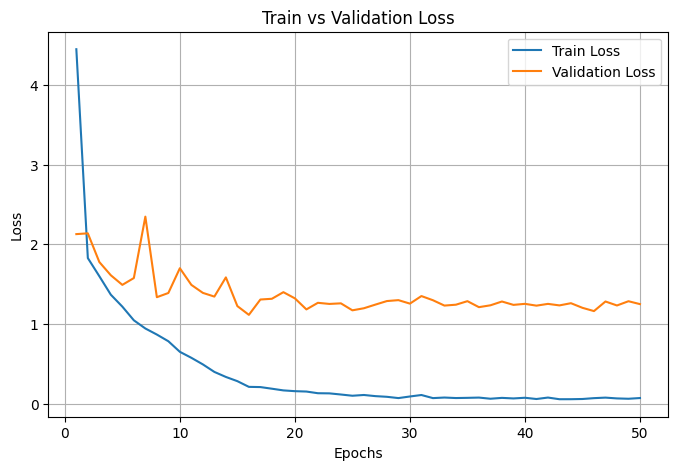

In [54]:
model = CNN3()
trained_model = train_model(model, train_loader, val_loader, epochs=50)

Accuracy: 0.5253
Precision: 0.5326, Recall: 0.5253, F1-score: 0.5220


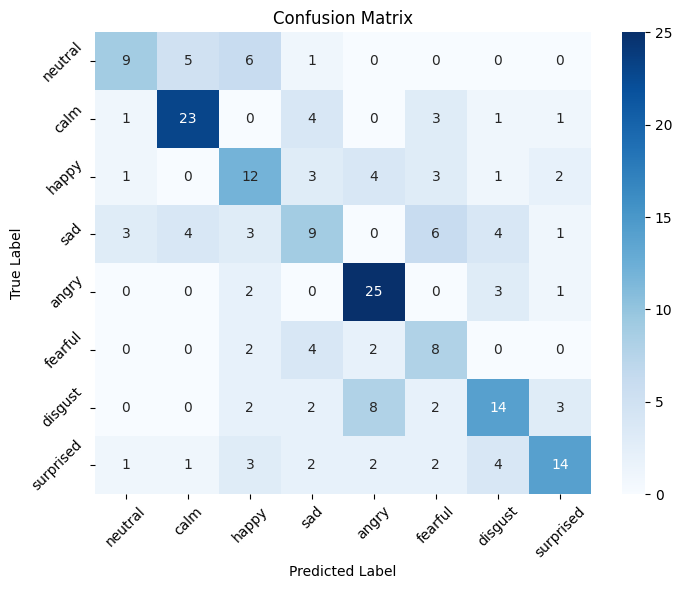

In [55]:
evaluate_model(trained_model, test_loader)

##### CNN 4 Layers

Epoch 1/50 - Train Loss: 2.8186, Train Acc: 0.1807, Val Loss: 2.1261, Val Acc: 0.1250
Epoch 2/50 - Train Loss: 1.8950, Train Acc: 0.2929, Val Loss: 2.3686, Val Acc: 0.1296
Epoch 3/50 - Train Loss: 1.6974, Train Acc: 0.3625, Val Loss: 2.0815, Val Acc: 0.2037
Epoch 4/50 - Train Loss: 1.5924, Train Acc: 0.3952, Val Loss: 1.7010, Val Acc: 0.3611
Epoch 5/50 - Train Loss: 1.4346, Train Acc: 0.4359, Val Loss: 1.8660, Val Acc: 0.3102
Epoch 6/50 - Train Loss: 1.3918, Train Acc: 0.4628, Val Loss: 1.5008, Val Acc: 0.4815
Epoch 7/50 - Train Loss: 1.1983, Train Acc: 0.5432, Val Loss: 1.5265, Val Acc: 0.4074
Epoch 8/50 - Train Loss: 1.1309, Train Acc: 0.5799, Val Loss: 1.5389, Val Acc: 0.4306
Epoch 9/50 - Train Loss: 0.9956, Train Acc: 0.6385, Val Loss: 1.5401, Val Acc: 0.4537
Epoch 10/50 - Train Loss: 0.9309, Train Acc: 0.6524, Val Loss: 1.4237, Val Acc: 0.4630
Epoch 11/50 - Train Loss: 0.8987, Train Acc: 0.6663, Val Loss: 1.3677, Val Acc: 0.5093
Epoch 12/50 - Train Loss: 0.7850, Train Acc: 0.7259,

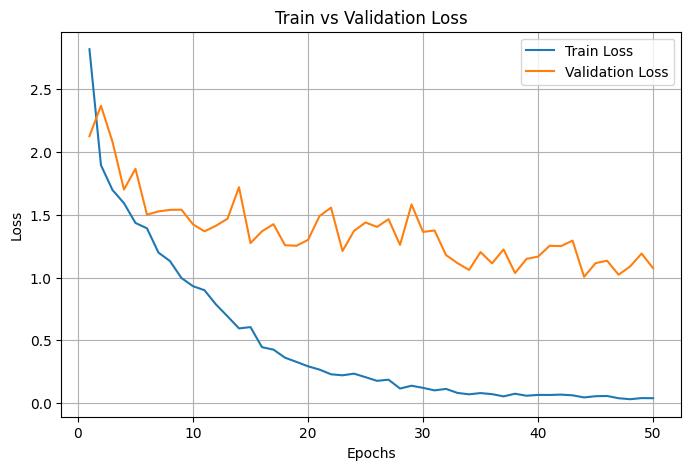

In [57]:
model = CNN4()
trained_model = train_model(model, train_loader, val_loader, epochs=50)

Accuracy: 0.5945
Precision: 0.6102, Recall: 0.5945, F1-score: 0.5968


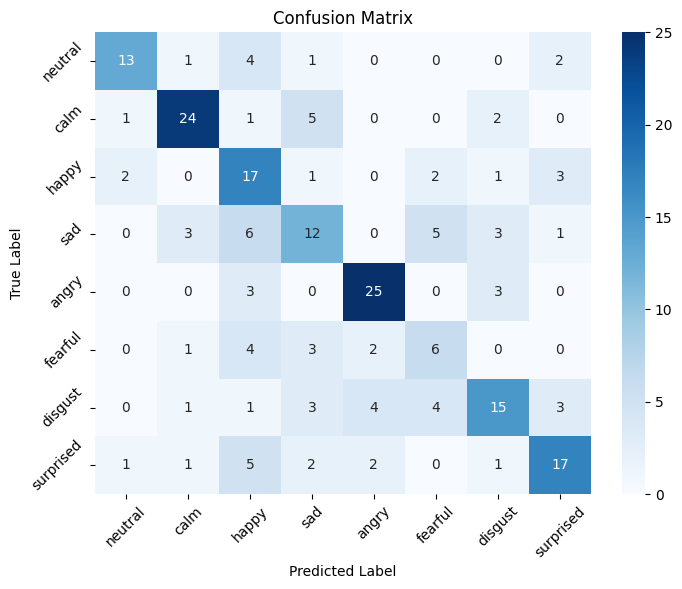

In [58]:
evaluate_model(trained_model, test_loader)

##### CNN 5 Layers

Epoch 1/50 - Train Loss: 2.4869, Train Acc: 0.1370, Val Loss: 2.1442, Val Acc: 0.1296
Epoch 2/50 - Train Loss: 2.0306, Train Acc: 0.1887, Val Loss: 2.1290, Val Acc: 0.1343
Epoch 3/50 - Train Loss: 1.9119, Train Acc: 0.2661, Val Loss: 1.9535, Val Acc: 0.1944
Epoch 4/50 - Train Loss: 1.8647, Train Acc: 0.2522, Val Loss: 1.8502, Val Acc: 0.3194
Epoch 5/50 - Train Loss: 1.7597, Train Acc: 0.3237, Val Loss: 1.8465, Val Acc: 0.2639
Epoch 6/50 - Train Loss: 1.6241, Train Acc: 0.3704, Val Loss: 1.8483, Val Acc: 0.2685
Epoch 7/50 - Train Loss: 1.5204, Train Acc: 0.4260, Val Loss: 1.6540, Val Acc: 0.3333
Epoch 8/50 - Train Loss: 1.5129, Train Acc: 0.4181, Val Loss: 1.6430, Val Acc: 0.3843
Epoch 9/50 - Train Loss: 1.4229, Train Acc: 0.4618, Val Loss: 1.6204, Val Acc: 0.3843
Epoch 10/50 - Train Loss: 1.3834, Train Acc: 0.4786, Val Loss: 1.7626, Val Acc: 0.3704
Epoch 11/50 - Train Loss: 1.2943, Train Acc: 0.5253, Val Loss: 1.8040, Val Acc: 0.3426
Epoch 12/50 - Train Loss: 1.3148, Train Acc: 0.5164,

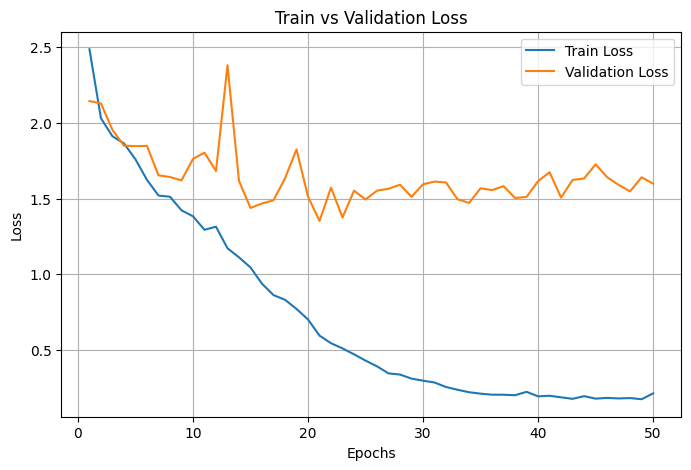

In [60]:
model = CNN5()
trained_model = train_model(model, train_loader, val_loader, epochs=50)

Accuracy: 0.5991
Precision: 0.6177, Recall: 0.5991, F1-score: 0.6022


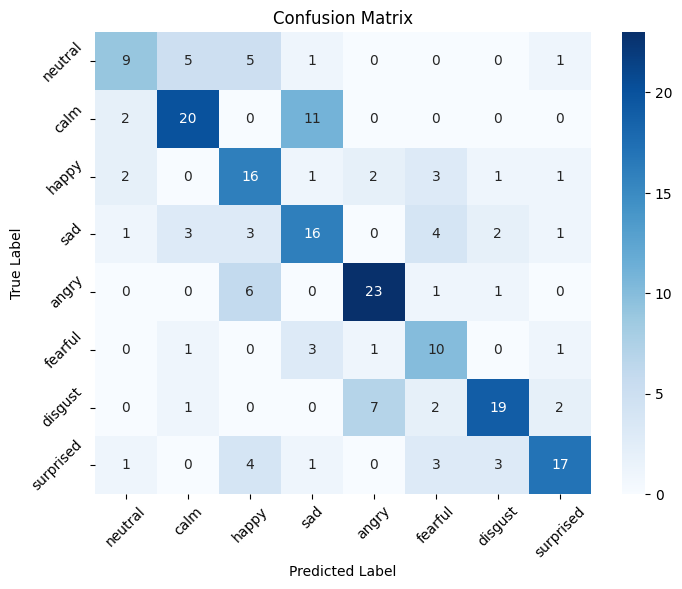

In [61]:
evaluate_model(model, test_loader)